In [1]:
# !pip install seaborn
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from scipy.stats import chi2 # norm
from scipy.special import erfinv
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from dt_utils import *
from sklearn import model_selection, preprocessing # datasets, tree, metrics, ensemble
from iminuit import Minuit
## import shuffle ##
from sklearn.utils import shuffle
# from keras.optimizers import Adam
# from six import StringIO
# import matplotlib.colors as colors
# from IPython.display import Image
# from mpl_toolkits.mplot3d import Axes3D
# import itertools
# import sklearn
# import keras
# import seaborn as sns

## auto display 100 columns ##
pd.set_option('display.max_columns', 100)

C:\Users\hanna\AppData\Local\Temp\ipykernel_2592\1534259712.py:4: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


# 3. Setup

In [2]:
## find csvs in the directory ##
data_dict = {}
keys = []
for dirname, _, filenames in os.walk('C:\\Users\\hanna\\Documents\\University\\Year 4\\DAML\\project 4\\'):
    for filename in filenames:
        if filename.endswith('.csv'):
            f = filename.split('\\')[-1].split('.')[0]
            keys.append(f)
            print('reading...', f)
            data_dict[f] = pd.read_csv(os.path.join(dirname, filename), index_col=0)

uncut_data_dict = data_dict.copy()

reading... Diboson
reading... ggH1000
reading... Top
reading... Zjets


In [3]:
data_dict[keys[1]].head()

,FullEventWeight,MET,Topology,Zll_mass,Zll_pt,fatjet_C2,fatjet_D2,fatjet_E,fatjet_eta,fatjet_phi,fatjet_pt,isSignal,lep1_E,lep1_charge,lep1_eta,lep1_phi,lep1_pt,lep2_E,lep2_charge,lep2_eta,lep2_phi,lep2_pt,reco_zv_mass,truth_zv_mass
0,0.013603,44495.770,1,87475.55,627990.80,0.116438,0.889354,675246.25,-0.851387,2.042860,480641.84,1,460743.97,1,-0.906080,-1.876361,320104.62,495510.120,-1,-1.034808,-1.631069,312638.44,1063465.80,999999.56
1,0.242178,34441.156,1,90507.31,409780.94,0.191874,1.485706,604275.70,1.041311,-0.817613,375352.78,1,1546717.50,-1,2.363212,2.032987,288589.78,579769.560,1,2.178999,2.466579,129548.62,974210.75,1000003.60
2,0.096412,21625.379,0,89765.85,344668.30,0.122089,1.219367,612517.94,0.417858,-2.133300,555879.20,1,420187.38,1,1.217848,0.664946,228625.23,333899.970,-1,1.695172,0.920596,118590.28,996837.40,999999.80
3,0.096373,21855.973,1,92313.63,535629.06,0.061306,0.592705,482630.90,0.438590,2.701475,430646.20,1,302820.03,-1,-0.045790,-0.626280,302502.84,243535.750,1,0.293053,-0.557273,233439.89,989655.56,1000008.80
4,0.073052,33677.380,1,89451.92,296257.47,0.159334,0.724910,459737.80,1.213717,-0.926707,244348.40,1,439221.78,1,-1.289961,2.238501,224785.02,98477.516,-1,-0.747040,2.647597,76205.98,993398.30,1000011.90


In [4]:
variables = ['lep1_pt', 'lep2_pt', 'fatjet_pt', 'fatjet_eta', 'fatjet_D2', 'Zll_mass', 
             'Zll_pt', 'MET', 'reco_zv_mass']
other_vars = ['isSignal', 'FullEventWeight']
bgd_uncropped = pd.concat([data_dict['Diboson'], data_dict['Top'], data_dict['Zjets']], axis=0)
sig_uncropped = data_dict['ggH1000']
bgd_cropped, sig_cropped = bgd_uncropped.copy(), sig_uncropped.copy()
print(bgd_uncropped.shape, sig_uncropped.shape)

(6826959, 24) (50013, 24)


## Cutting the data
Plot the kinematic distributions for each process and overlay them. 
Decide “by eye” on the kind of “square” cuts you want to apply (e.g. lep1 pt > 100000, or fatjet pt > 150000, etc. ) in order to make the signal peak more apparent on the reco zv mass spectrum. It is not necessary to do a thorough selection optimisation at this point, we just want to end up with a set of reasonable kinematic cuts that render the signal more visible. 
Do not apply any kinematic cuts on variable reco zv mass.

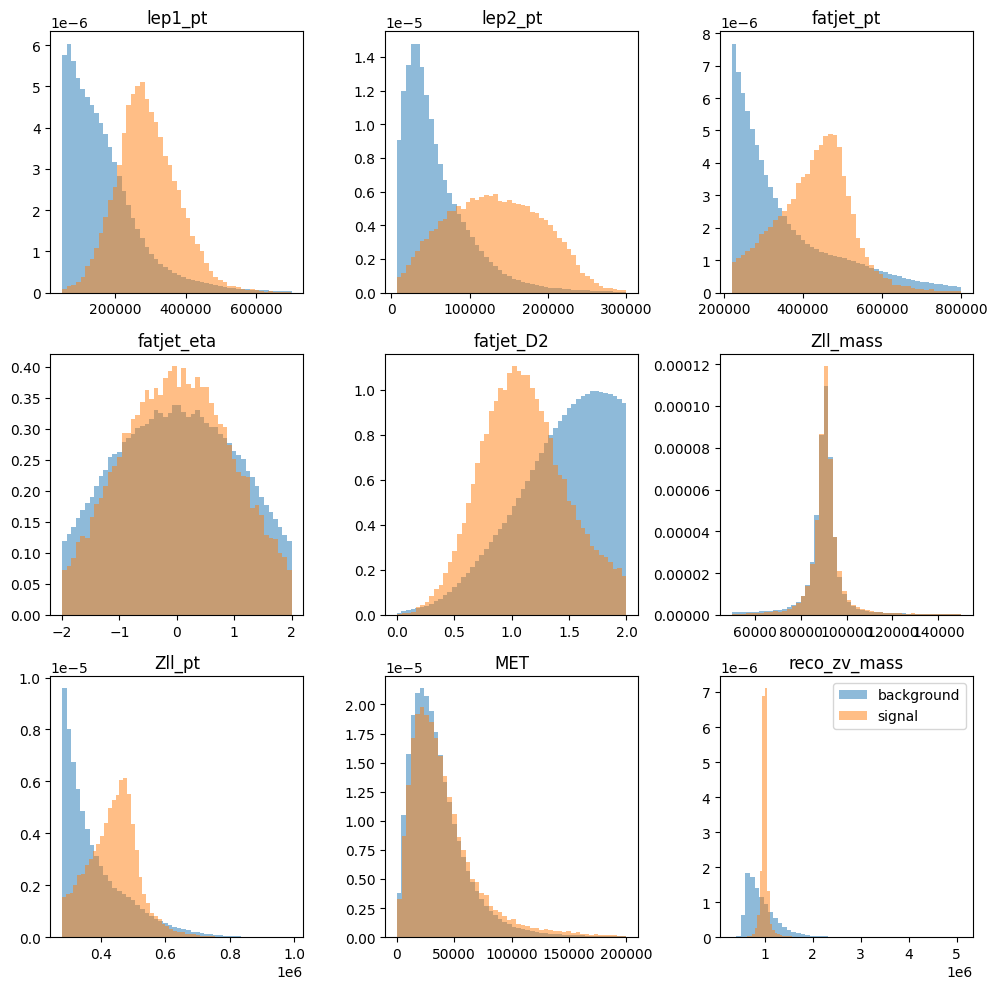

In [5]:
cut_dict = {'lep1_pt': (0.05e6, 0.7e6), 'lep2_pt':(0, .3e6), 'fatjet_pt':(0.22e6, .8e6), 'fatjet_eta':(-2, 2), 
            'fatjet_D2':(0, 2), 'Zll_mass':(0.05e6, 0.15e6), 
             'Zll_pt':(0.28e6, 1e6), 'MET':(0, 0.2e6)}
fig, ax = plt.subplots(3, 3, figsize=(10, 10))
kawrgs = dict(bins=50, density=True, alpha=0.5)

for i, var in enumerate(variables):
    if var != 'reco_zv_mass':  
        bgd_cropped = bgd_cropped[(bgd_cropped[var] > cut_dict[var][0]) & (bgd_cropped[var] < cut_dict[var][1])]
        sig_cropped = sig_cropped[(sig_cropped[var] > cut_dict[var][0]) & (sig_cropped[var] < cut_dict[var][1])]
    ax[i//3, i%3].hist(bgd_cropped[var], label='background', **kawrgs) # , weights=bgd[other_vars[-1]]
    ax[i//3, i%3].hist(sig_cropped[var], label='signal', **kawrgs) # weights=sig[other_vars[-1]],
    ax[i//3, i%3].set_title(var)

plt.legend()
plt.tight_layout()
plt.show()

In [6]:
## cropping the the reco_zv_mass range where the signal is to fit ##
low, high = 0.85e6, 1.15e6
bgd_cropped = bgd_cropped[(bgd_cropped['reco_zv_mass'] > low) & (bgd_cropped['reco_zv_mass'] < high)]
sig_cropped = sig_cropped[(sig_cropped['reco_zv_mass'] > low) & (sig_cropped['reco_zv_mass'] < high)]


In [7]:
def plot_reco_zv_mass_hist(bgd, sig):
    ## plotting before the cropping ##
    bgdy, bgdbins,_ = plt.hist(bgd['reco_zv_mass'], label='background', weights=bgd['FullEventWeight'], bins=100, alpha=0.5)
    sigy, sigbins,_ = plt.hist(sig['reco_zv_mass'], label='signal', weights=sig['FullEventWeight'], bins=100, alpha=0.5)
    ## x coordinate of the bins ##
    bgdx, sigx = np.zeros_like(bgdy), np.zeros_like(sigy) # of reco_zv_mass
    bgd_sumweight_sq, sig_sumweight_sq = np.zeros_like(bgdy), np.zeros_like(sigy)
    bgd_sumweight, sig_sumweight = np.zeros_like(bgdy), np.zeros_like(sigy)

    ## loop through the number of bins ##
    for i in range(len(bgdy)):
        ## converting bins to centre of bins ##
        bgdx[i] = (bgdbins[i] + bgdbins[i+1])/2
        sigx[i] = (sigbins[i] + sigbins[i+1])/2
        ## finding the sum of weights in each bin ##
        bgd_sumweight_sq[i] = np.sum((bgd['FullEventWeight'][ (bgd['reco_zv_mass'] > bgdbins[i]) & 
                                    (bgd['reco_zv_mass'] < bgdbins[i+1]) ])**2)
        sig_sumweight_sq[i] = np.sum((sig['FullEventWeight'][ (sig['reco_zv_mass'] > sigbins[i]) & 
                                    (sig['reco_zv_mass'] < sigbins[i+1]) ])**2)

        bgd_sumweight[i] = np.sum(bgd['FullEventWeight'][ (bgd['reco_zv_mass'] > bgdbins[i]) & 
                                    (bgd['reco_zv_mass'] < bgdbins[i+1]) ])
        sig_sumweight[i] = np.sum(sig['FullEventWeight'][ (sig['reco_zv_mass'] > sigbins[i]) & 
                                    (sig['reco_zv_mass'] < sigbins[i+1]) ])


    plt.scatter(bgdx, bgdy, label='background fit data', alpha=0.8)
    plt.scatter(sigx, sigy, label='signal fit data', alpha=0.8)
    plt.legend()
    plt.title('Signal and Background data')
    # plt.plot(bgdx, line(bgdx, 4000, -1/375))
    # plt.plot(sigx, gaussian(sigx, 1e6, 0.8e4, 80))
    plt.show()

    print('fraction of signal events:', 100*np.trapz(sigy, sigx)/np.trapz(sigy+bgdy, sigx+bgdx), '%')

    return bgdx, bgdy, bgd_sumweight_sq, bgd_sumweight, sigx, sigy, sig_sumweight_sq, sig_sumweight

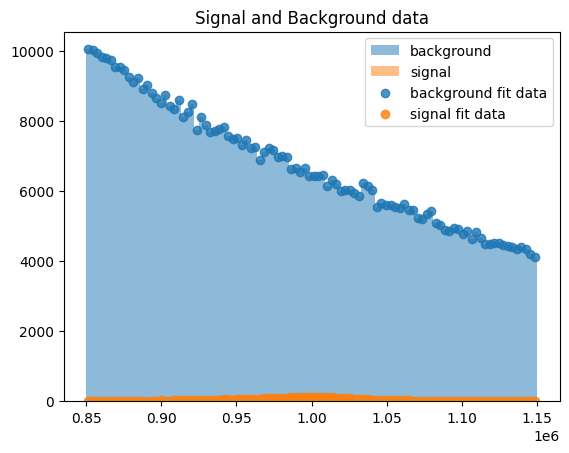

fraction of signal events: 0.2844764415747688 %


In [8]:
_,_,_,_,_,_,_,_ = plot_reco_zv_mass_hist(bgd_uncropped[(bgd_uncropped['reco_zv_mass'] > low) & (bgd_uncropped['reco_zv_mass'] < high)], 
                       sig_uncropped[(sig_uncropped['reco_zv_mass'] > low) & (sig_uncropped['reco_zv_mass'] < high)])

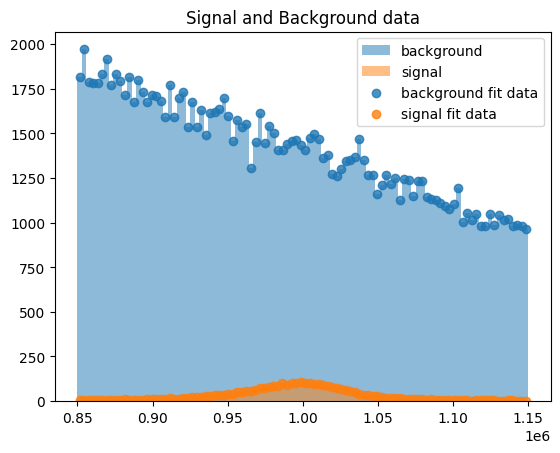

fraction of signal events: 1.090185020633495 %


In [9]:
bgdx, bgdy, bgd_sumweight_sq, bgd_sumweight, sigx, sigy, sig_sumweight_sq, sig_sumweight = plot_reco_zv_mass_hist(bgd_cropped, sig_cropped)

The fraction of signal events has incresed by 3 fold

# 4. Fitting and Hypothesis Testing
Functions for fitting the cropped data below to feed into minuit

I tried fitting a double gaussian to the signal but the fit was not as good as a lorentzian :)

In [10]:
def gaussian( x, mean, sigma1, sigma2, a, b):
    g1 = a * np.exp( - 0.5 * ( (x-mean)/sigma1 )**2)
    g2 = b * np.exp( - 0.5 * ( (x-mean)/sigma2 )**2)
    return g1 + g2


def lorentzian( x, mean, gamma, a):
    return a / (1 + ((x-mean)/gamma)**2)


def line( x, intercept, slope ):
    return intercept + slope * x


## to fit signal alone ##
def chi2_sig( mean, sigma1, sigma2, a, b): # signal present 
    n_pred = gaussian( sigx, mean, sigma1, sigma2, a, b )
    # n_pred[n_pred<=0] = 1e-5  # to prevent dividing by 0
    return np.sum((sig_sumweight - n_pred)**2 / sig_sumweight_sq)


def chi2_sig_lorentz( mean, gamma, a): # signal present 
    n_pred = lorentzian( sigx, mean, gamma, a)
    return np.sum((sig_sumweight - n_pred)**2 / sig_sumweight_sq)


## to fit background alone ##
def chi2_bgd( intercept, slope ): # signal present 
    n_pred = line( bgdx, intercept, slope )
    return np.sum((bgd_sumweight - n_pred)**2 / bgd_sumweight_sq)

### Starting values for the seperate background and signal fits
Fitting on the subrange of the reco_zv_mass

In [11]:
sig_startvals = {'mean':1.0e6, 'sigma1':0.8e4, 'sigma2':80, 'a':4000, 'b':-1/375}
sig_startvals_lorentz = {'mean':1.0e6, 'gamma':0.8e4, 'a':4000}
bgd_startvals = {'intercept':4000, 'slope':-1/375}

In [12]:
m_sig = Minuit(chi2_sig_lorentz, **sig_startvals_lorentz)
m_sig.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 672.6                      │              Nfcn = 116              │
│ EDM = 3.3e-12 (Goal: 0.0002)     │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ mean  │ 994.91e3  │  0.28e3   │            │            │         │         │       │
│ 1 │ gamma │ -30.12e3  │  0.26e3   │            │            │         │         │       │
│ 2 │ a     │   109.5   │    1.1    │            │            │         │         │       │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───────┬────────────────────────────┐
│       │     mean    gamma        a │
├───────┼────────────────────────────┤
│  mean │ 7.69e+04   0.02e6     53.3 │
│ gamma │   0.02e6 6.99e+04    220.1 │
│     a │     53.3    220.1     1.14 │
└───────┴────────────────────────────┘

In [13]:
m_bgd = Minuit(chi2_bgd, **bgd_startvals)
m_bgd.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 102.2                      │              Nfcn = 35               │
│ EDM = 1.3e-19 (Goal: 0.0002)     │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬───────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name      │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ intercept │  4.45e3   │  0.06e3   │            │            │         │         │       │
│ 1 │ slope     │ -3.04e-3  │  0.06e-3  │            │            │         │         │       │
└───┴───────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───────────┬───────────────────────────┐
│           │    intercept        slope │
├───────────┼───────────────────────────┤
│ intercept │     4.18e+03 -4.085275e-3 │
│     slope │ -4.085275e-3     4.02e-09 │
└───────────┴───────────────────────────┘

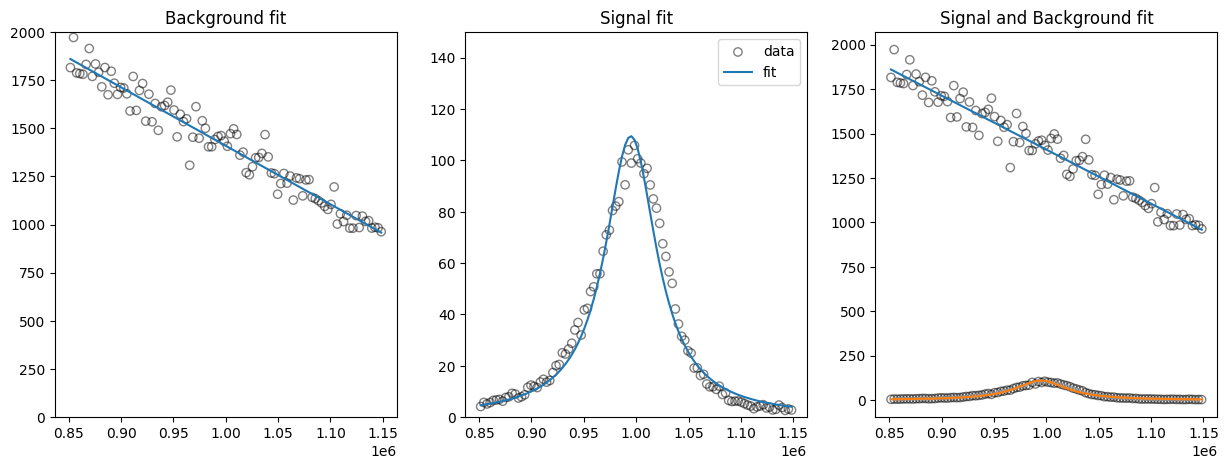

In [14]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
kawrgs = dict(alpha=0.5, facecolor='none', edgecolor='black')
ax[0].scatter(bgdx, bgdy, **kawrgs)
ax[0].plot(bgdx, line(bgdx, *m_bgd.values))
ax[0].set(ylim=(0, 2000), title='Background fit')
ax[1].scatter(sigx, sigy, label='data', **kawrgs)
ax[1].plot(sigx, lorentzian(sigx, *m_sig.values), label='fit')
ax[1].set(ylim=(0, 150), title='Signal fit')
ax[2].scatter(bgdx, bgdy, **kawrgs)
ax[2].scatter(sigx, sigy, **kawrgs)
ax[2].plot(bgdx, line(bgdx, *m_bgd.values), label='background fit')
ax[2].plot(sigx, lorentzian(sigx, *m_sig.values), label='signal fit')
ax[2].set(title='Signal and Background fit')
ax[1].legend()
plt.show()

In [15]:
chi2_sig_val, chi2_bgd_val = chi2_sig_lorentz(*m_sig.values), chi2_bgd(*m_bgd.values)   
print('chi2 signal:', round(chi2_sig_val, 3), '\nchi2 background:', round(chi2_bgd_val, 3))

chi2 signal: 672.573 
chi2 background: 102.237


## Modelling joint signal + background

In [16]:
## for fitting the combined signal and background ##
def bgd_sig(intercept, slope, c):
    return line( bgdx, intercept, slope ) + c * lorentzian(sigx, *m_sig.values)


def chi2_combined(intercept, slope, c):
    n_pred = bgd_sig(intercept, slope, c)
    y = bgd_sumweight + sig_sumweight
    y_sum_sq = bgd_sumweight_sq + sig_sumweight_sq
    return np.sum((y-n_pred)**2 / y_sum_sq)

In [17]:
comb_startvals = {'intercept': 4000, 'slope': -1/375, 'c': 1}
m_comb = Minuit(chi2_combined, **comb_startvals)
m_comb.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 101.5                      │              Nfcn = 57               │
│ EDM = 1.22e-17 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬───────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name      │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ intercept │  4.44e3   │  0.07e3   │            │            │         │         │       │
│ 1 │ slope     │ -3.04e-3  │  0.06e-3  │            │            │         │         │       │
│ 2 │ c         │   1.22    │   0.18    │            │            │         │         │       │
└───┴───────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───────────┬────────────────────────────────────────┐
│           │    intercept        slope            c │
├───────────┼────────────────────────────────────────┤
│ intercept │     4.43e+03 -4.248049e-3       -2.827 │
│     slope │ -4.248049e-3     4.13e-09     1.860e-6 │
│         c │       -2.827     1.860e-6       0.0326 │
└───────────┴────────────────────────────────────────┘

In [18]:
values = m_comb.values
errors = m_comb.errors
chi2_H1 = m_comb.fval
print('chi2:', round(chi2_H1, 3))

chi2: 101.501


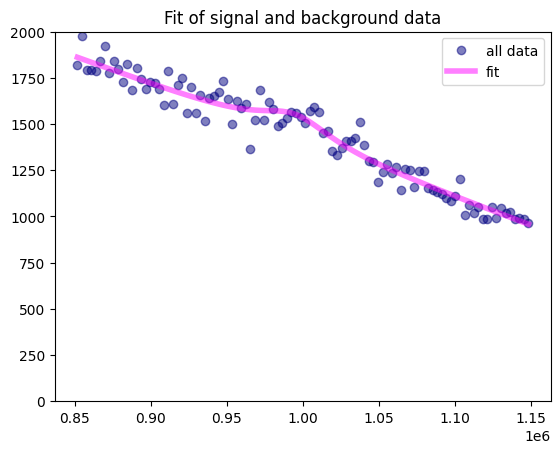

In [19]:
plt.errorbar(sigx, sigy+bgdy, label='all data', alpha=0.5, fmt='o', color='#000080')
plt.errorbar(sigx, bgd_sig(*values), label='fit', color='magenta', alpha=0.5, lw=4)
plt.legend()
plt.ylim(0, 2000)
plt.title('Fit of signal and background data')
plt.show()

## Modelling just the background
With a line

In [20]:
## to fit background alone ##
def chi2_just_bgd( intercept, slope ): # signal present 
    x, sumweight, sumweight_sq = bgdx, bgd_sumweight+sig_sumweight, bgd_sumweight_sq+sig_sumweight_sq
    n_pred = line( x, intercept, slope )
    return np.sum((sumweight - n_pred)**2 / sumweight_sq)

In [21]:
just_bgd_startvals = {'intercept':4800, 'slope':-1/300}
m_just_bgd = Minuit(chi2_just_bgd, **bgd_startvals)
m_just_bgd.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 146.8                      │              Nfcn = 35               │
│ EDM = 8.34e-20 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬───────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name      │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ intercept │  4.55e3   │  0.06e3   │            │            │         │         │       │
│ 1 │ slope     │ -3.11e-3  │  0.06e-3  │            │            │         │         │       │
└───┴───────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───────────┬───────────────────────────┐
│           │    intercept        slope │
├───────────┼───────────────────────────┤
│ intercept │     4.19e+03 -4.086957e-3 │
│     slope │ -4.086957e-3     4.02e-09 │
└───────────┴───────────────────────────┘

In [22]:
values = m_just_bgd.values
errors = m_just_bgd.errors
chi2_H0 = m_just_bgd.fval
print('chi2:', round(chi2_H0, 3))

chi2: 146.756


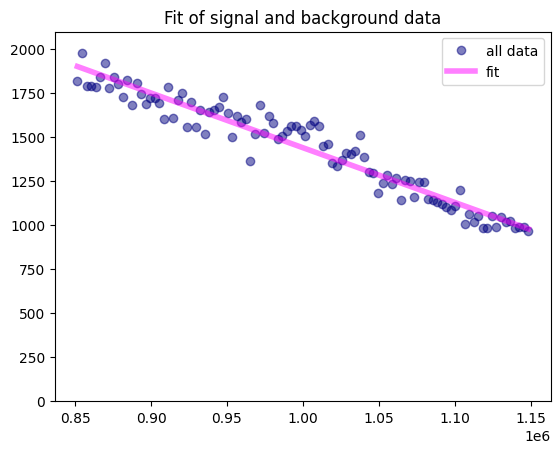

In [23]:
plt.errorbar(bgdx, sigy+bgdy, label='all data', alpha=0.5, fmt='o', color='#000080')
plt.errorbar(bgdx, line(bgdx, *values), label='fit', color='magenta', alpha=0.5, lw=4)
plt.legend()
plt.ylim(0, 2100)
plt.title('Fit of signal and background data')
plt.show()

## Using Wilk's theorem

In [24]:
# calculate relevent values
chi2_diff = chi2_H0 - chi2_H1
z_score = np.sqrt(chi2_diff)
p_value = 1-chi2.cdf(chi2_diff, 1)
std = erfinv(1 - p_value) * np.sqrt(2)
print('Chi^2 H_0=', round(chi2_H0, 3), '\nChi^2 H_1=', round(chi2_H1, 3))
print('Chi^2 diff:', round(chi2_diff, 3))
print('\np-value:', p_value, '\nstd:', round(std, 1))

Chi^2 H_0= 146.756 
Chi^2 H_1= 101.501
Chi^2 diff: 45.255

p-value: 1.7299717214314114e-11 
std: 6.7


# 5. Employing a NN classifier
Create a NN classifier using the input features listed in Table 1. Do not use
reco zv mass (or FullEventWeight), though. Probably the most important decision you will have to make is which dataset to use for the training of the N classifier.


Should you use the original datasets before any selection cuts? Or the
filtered datasets after having applying the selection cuts of the previous Section? Or
maybe some intermediate choice with some looser selection cuts? Strictly speaking,
there is no “correct” answer here, but some approaches work better than others.

Editing the new input variables below:

In [25]:
input_variables = ['lep1_pt', 'lep2_pt', 'fatjet_pt', 'fatjet_eta', 'fatjet_D2', 'Zll_mass', 'Zll_pt', 'MET'] # , 'reco_zv_mass'
target_variable = ['isSignal'] # , 'FullEventWeight'
bgd_uncut = pd.concat([uncut_data_dict['Diboson'], uncut_data_dict['Top'], uncut_data_dict['Zjets']], axis=0)
sig_uncut = uncut_data_dict['ggH1000']
sig_counts, bgs_counts = sig_uncut.shape[0], bgd_uncut.shape[0]
print(bgd_uncut.shape, sig_uncut.shape)

(6826959, 24) (50013, 24)


## Plotting the features for the different cuts

In [26]:
loose_cut_dict = {'lep1_pt': (0, 1e6), 'lep2_pt':(0, 0.5e6), 'fatjet_pt':(0, 1e6), 'fatjet_eta':(-2, 2), 
                 'fatjet_D2':(0, 10), 'Zll_mass':(0, 0.4e6), 
                 'Zll_pt':(0, 2e6), 'MET':(0, 0.4e6)}

In [27]:
def perform_cuts(cut_dict, cut_reco=False):
    fig, ax = plt.subplots(3, 3, figsize=(10, 10))
    kawrgs1 = dict(bins=100, density=True, alpha=0.5)
    bgd = bgd_uncut.copy()
    sig = sig_uncut.copy()

    for i, var in enumerate(input_variables):
        if cut_dict != None:
            bgd = bgd[(bgd[var] > cut_dict[var][0]) & 
                                (bgd[var] < cut_dict[var][1])]
            sig = sig[(sig[var] > cut_dict[var][0]) & 
                                (sig[var] < cut_dict[var][1])]
        ax[i//3, i%3].hist(bgd[var], label='bgd', **kawrgs1) # , weights=bgd[other_vars[-1]]
        ax[i//3, i%3].hist(sig[var], label='sig', **kawrgs1) # weights=sig[other_vars[-1]],
        ax[i//3, i%3].set_title(var)
    if cut_reco:
        bgd = bgd[(bgd['reco_zv_mass'] > cut_dict['reco_zv_mass'][0]) & 
                                (bgd['reco_zv_mass'] < cut_dict['reco_zv_mass'][1])]
        sig = sig[(sig['reco_zv_mass'] > cut_dict['reco_zv_mass'][0]) & 
                            (sig['reco_zv_mass'] < cut_dict['reco_zv_mass'][1])]


    ax[2, 2].hist(bgd['reco_zv_mass'], label='bgd', **kawrgs1) # , weights=bgd[other_vars[-1]]
    ax[2, 2].hist(sig['reco_zv_mass'], label='sig', **kawrgs1) # weights=sig[other_vars[-1]],
    ax[2, 2].set_title('reco_zv_mass')

    ax[0, 2].legend()
    # ax[2, 2].axis('off')
    plt.tight_layout()
    plt.show()

    sig_counts, bgs_counts = sig.shape[0], bgd.shape[0]
    print(bgd.shape, sig.shape)
    return bgd, sig, sig_counts, bgs_counts

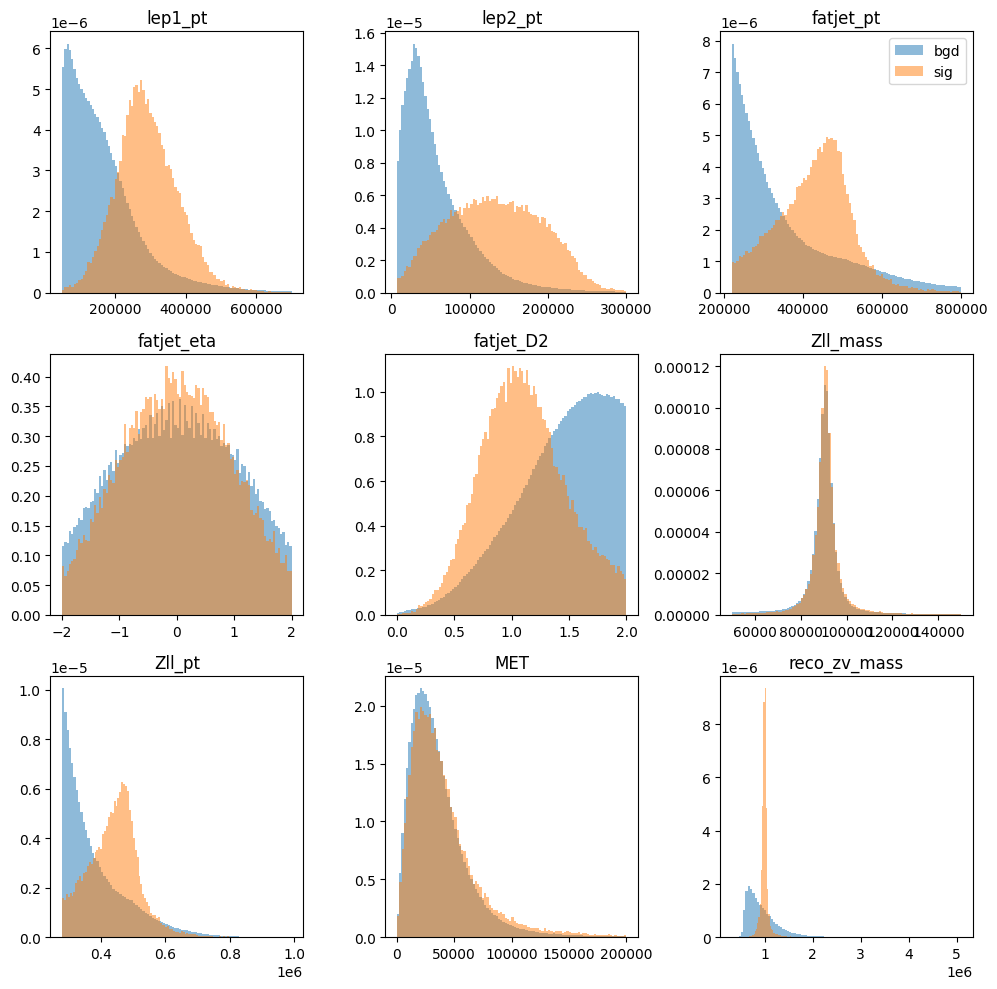

(597884, 24) (39471, 24)


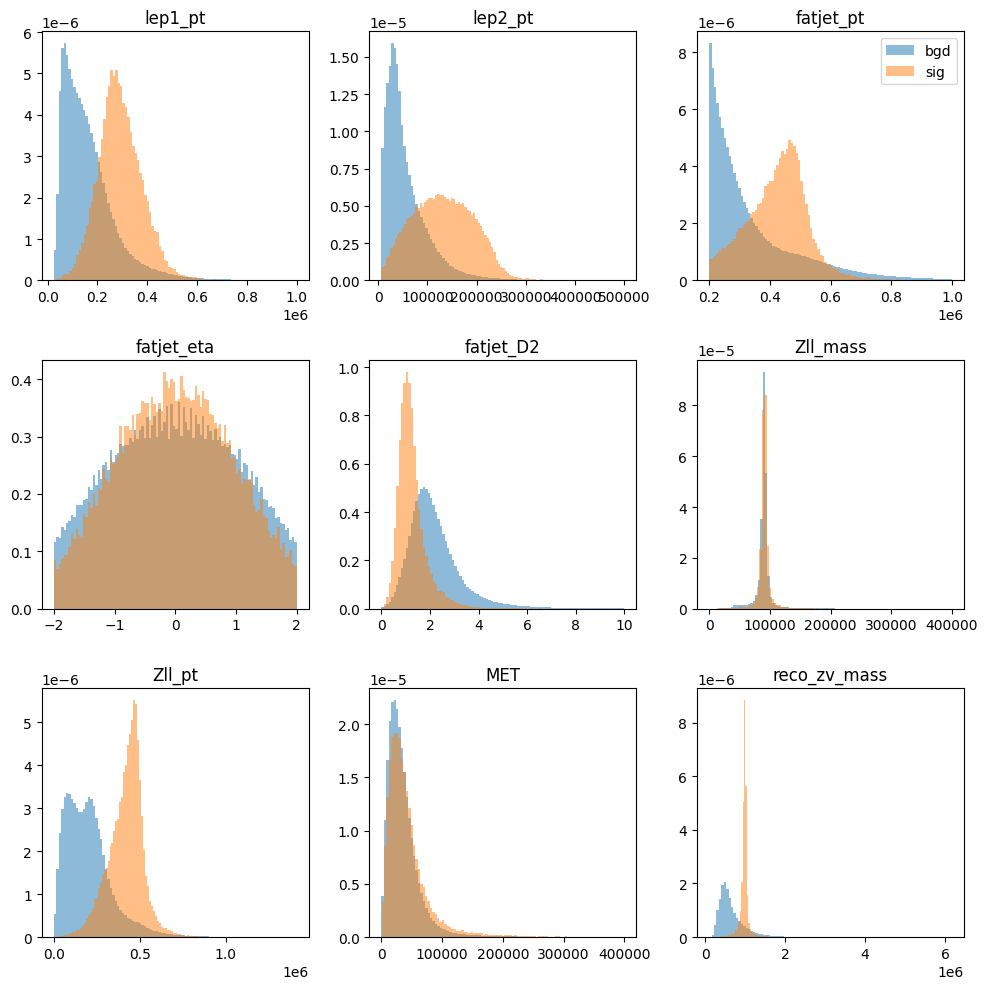

(6551742, 24) (49752, 24)


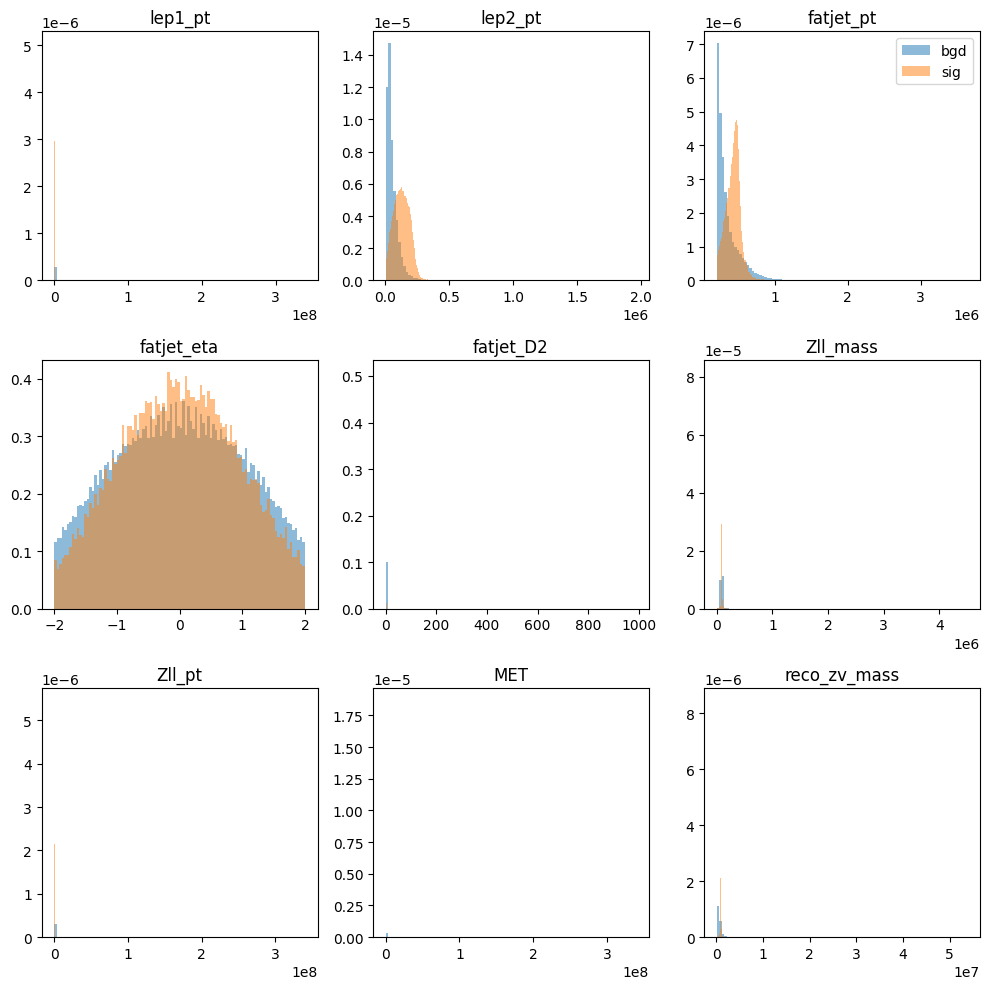

(6826959, 24) (50013, 24)


In [28]:
## plotting all of the different cuts ## bgd, sig, sig_counts, bgs_counts

bgd_harsh_cut, sig_harsh_cut, sig_harsh_count, bgd_harish_count = perform_cuts(cut_dict)
bgd_loose_cut, sig_loose_cut, sig_loose_count, bgd_loose_counts = perform_cuts(loose_cut_dict)
bgd_no_cut, sig_no_cut, sig_nocut_coutn, bgd_nocut_count = perform_cuts(None)

In [29]:
## make 50-50 split bgd and sig ##
def get_train_test_split(bgd_data, sig_data, counts):
    split_data = pd.concat([shuffle(bgd_data, random_state=42).iloc[0:counts], sig_data], axis=0, ignore_index=True)
    split_data = shuffle(split_data, random_state=42)
    input_data = split_data[input_variables] # restrict to input variables
    target = split_data[target_variable] # restrict to IsSignal
    print('Number of variables used: ', len(input_variables))

    train_data, test_data, train_target, test_target = model_selection.train_test_split(input_data, target, 
                                                                                        test_size=0.3, 
                                                                                        random_state=42)
    print('Shapes of test train data:\n',
        train_data.shape, test_data.shape, train_target.shape, test_target.shape)

    return train_data, test_data, train_target, test_target

In [30]:
def plot_corr(bgd, sig, title):
    train_data, test_data, train_target, test_target = get_train_test_split(bgd, sig, sig_uncut.shape[0])
    corr = train_data.corr()
    ## Set the diagonal to 0 ##
    for i in range(len(corr.columns)):
        corr.iloc[i, i] = 0
    plt.matshow(corr)
    plt.xticks(range(train_data.shape[1]), train_data.columns, fontsize=10, rotation=45)
    plt.yticks(range(train_data.shape[1]), train_data.columns, fontsize=10)
    cb = plt.colorbar()
    plt.title(f'Correlation matrix of {title}')
    corr_mean = corr.mean().mean()
    print('\ncorrelation mean:',corr_mean)
    plt.show()

### Below correlations
The uncut data has the highest correlation (see below). Therefore I have decided to use the uncut data to use for the NN traning.

Number of variables used:  8
Shapes of test train data:
 (70018, 8) (30008, 8) (70018, 1) (30008, 1)

correlation mean: 0.11737844560571994


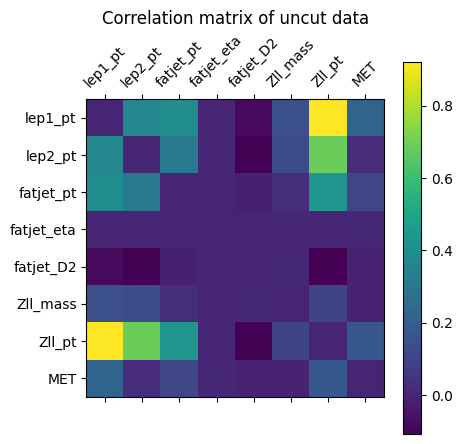

Number of variables used:  8
Shapes of test train data:
 (69835, 8) (29930, 8) (69835, 1) (29930, 1)

correlation mean: 0.08956961969594493


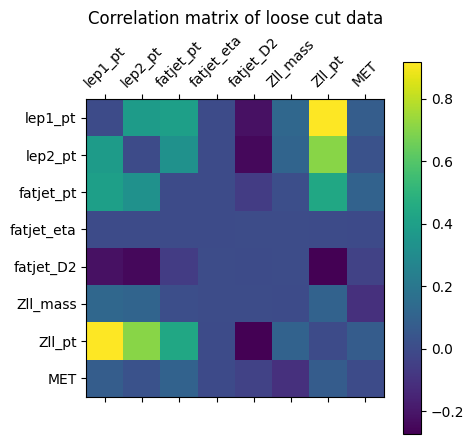

Number of variables used:  8
Shapes of test train data:
 (62638, 8) (26846, 8) (62638, 1) (26846, 1)

correlation mean: 0.06974595637087039


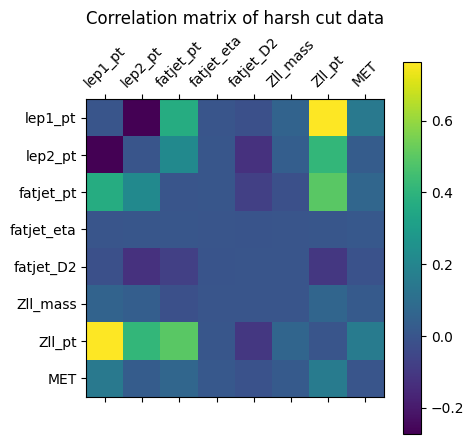

In [31]:
plot_corr(bgd_uncut, sig_uncut,'uncut data')
plot_corr(bgd_loose_cut, sig_loose_cut, 'loose cut data')
plot_corr(bgd_harsh_cut, sig_harsh_cut, 'harsh cut data')

### Feature plot for the uncut data

Number of variables used:  8
Shapes of test train data:
 (70018, 8) (30008, 8) (70018, 1) (30008, 1)
number features:  8
number of pairs: 28


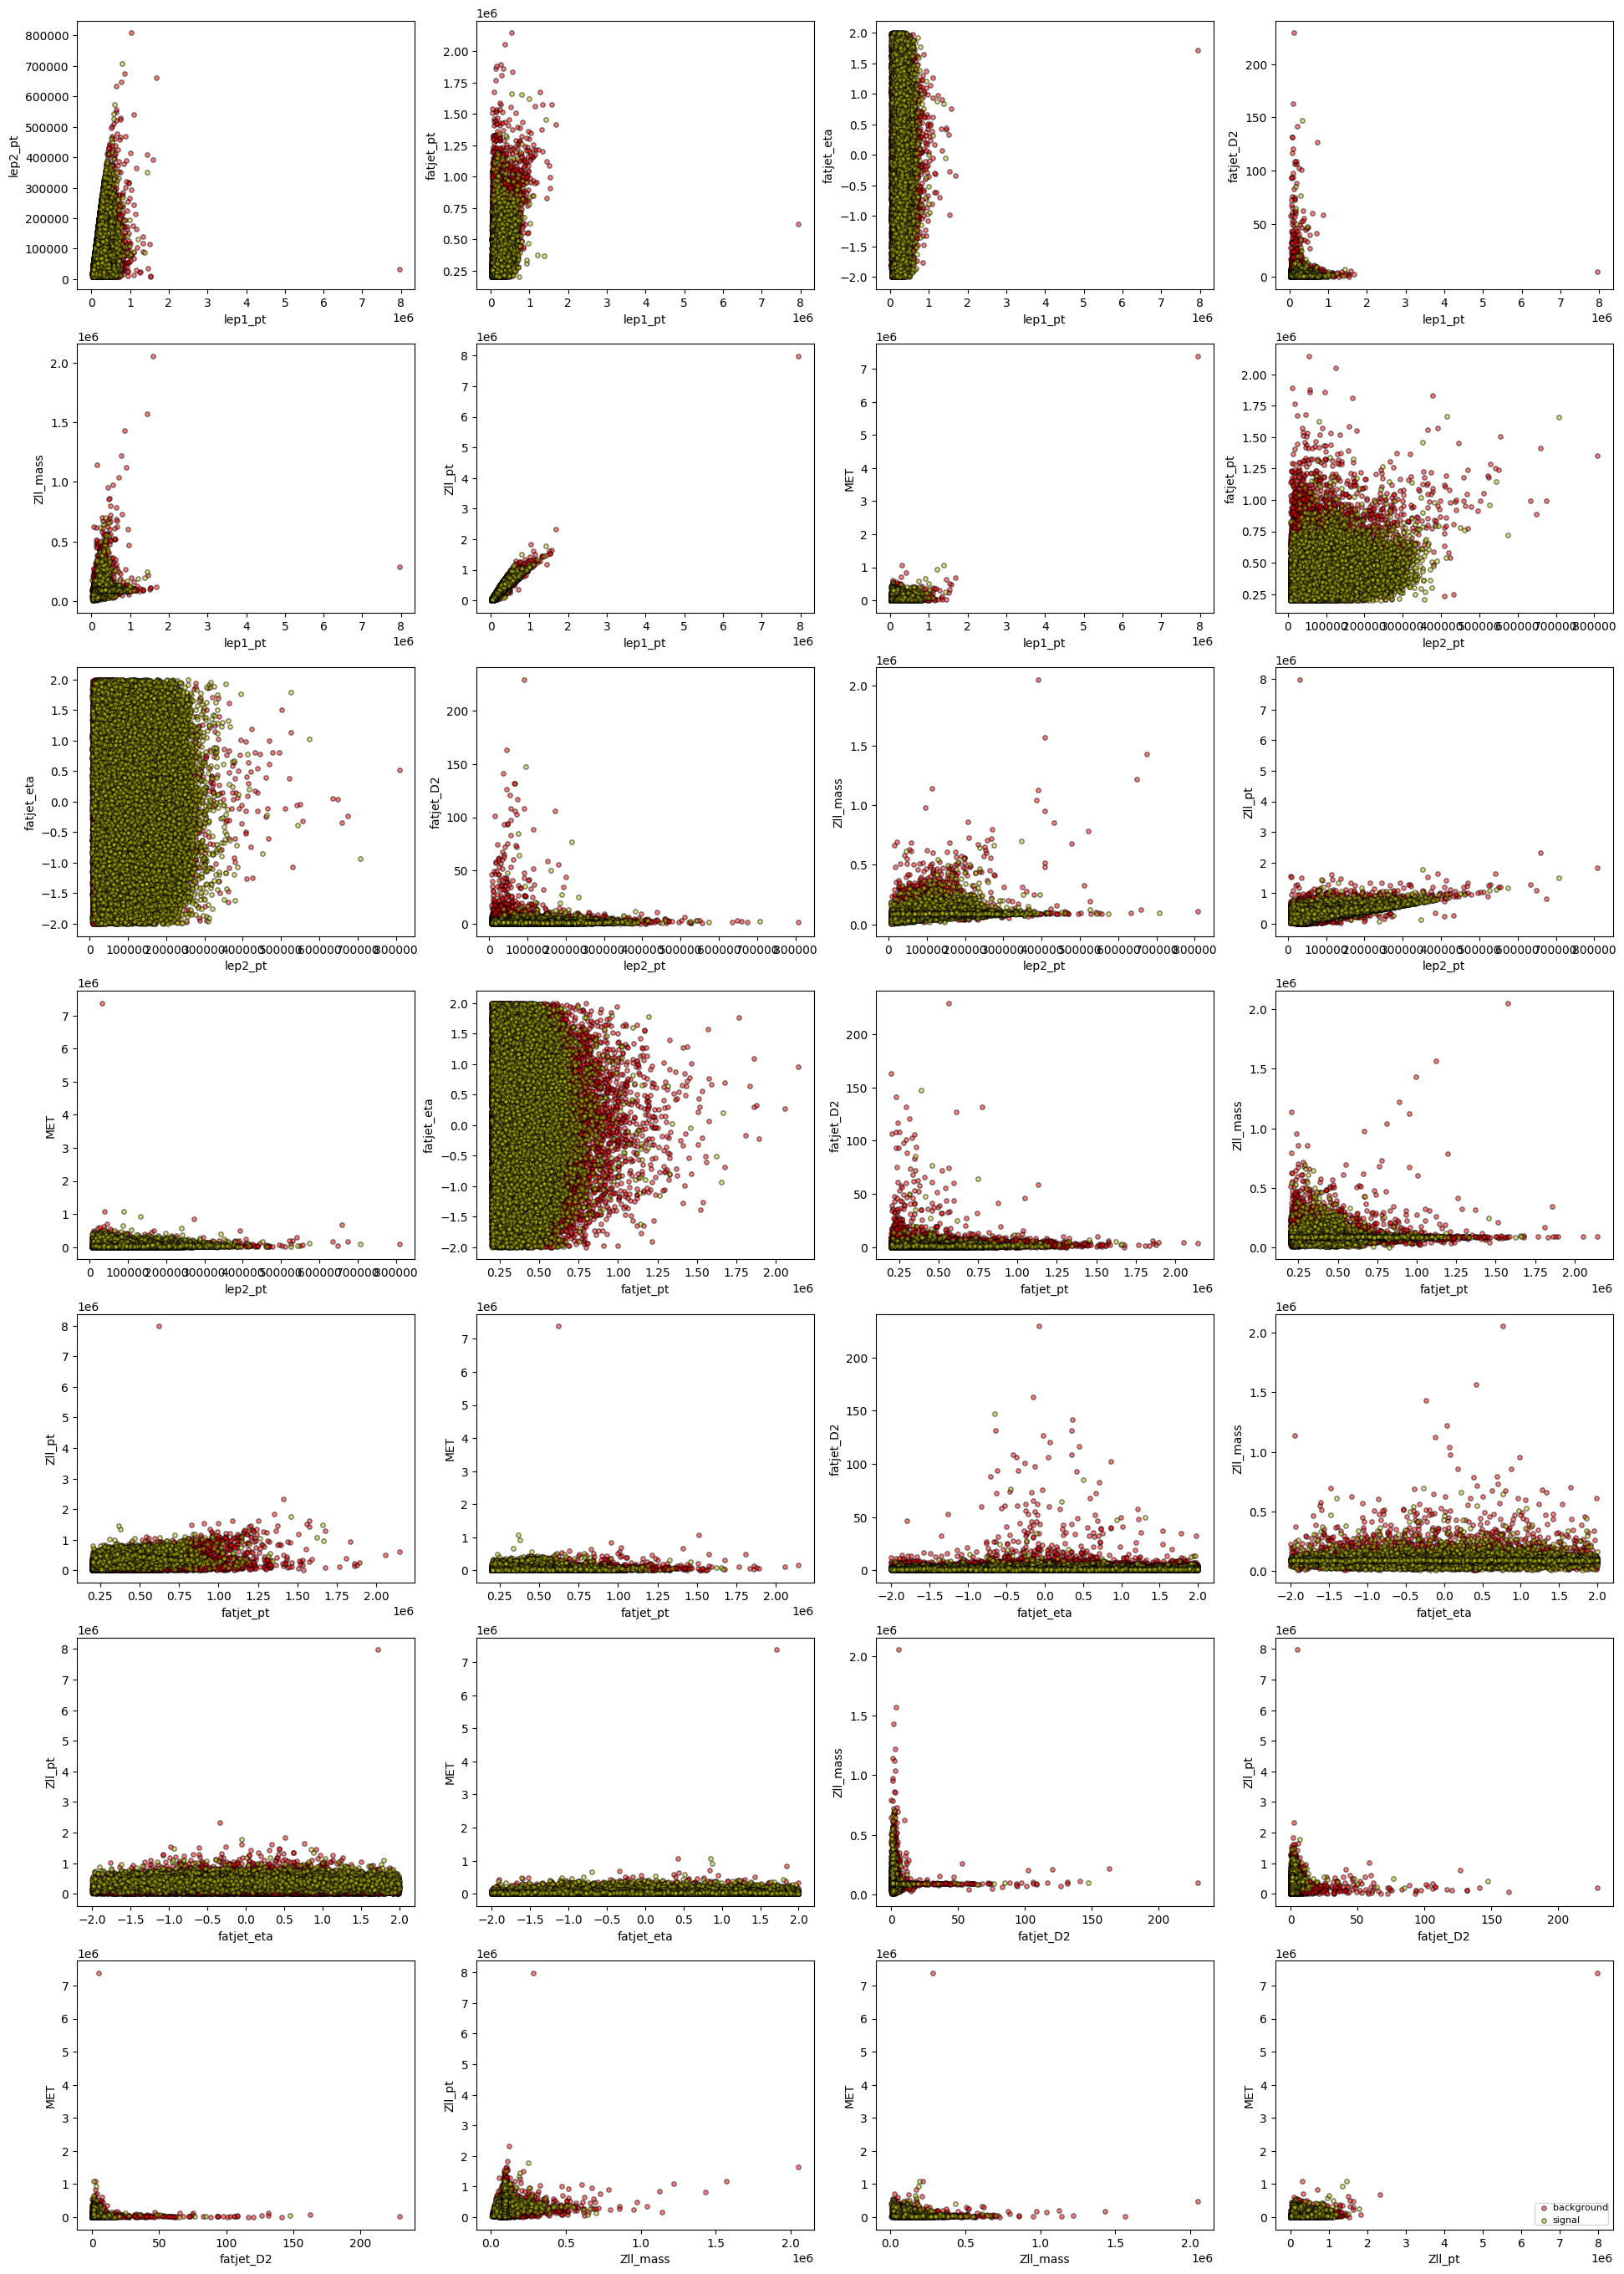

In [32]:
train_data, test_data, train_target, test_target = get_train_test_split(bgd_no_cut, sig_no_cut, sig_uncut.shape[0])
featureplot(train_data, train_target, 2, t_names=input_variables, c_names=['background', 'signal'])
plt.show()

## Training the model

In [33]:
num_outputs = 1
batchSize = 500
N_epochs = 100
n_nodes = 20
depth = 3

In [34]:
def my_model(num_inputs, num_nodes, extra_depth, metric='accuracy'):
    ## create model ##
    model = Sequential()
    model.add(Dense(num_nodes, input_dim=num_inputs, kernel_initializer='normal', activation='relu'))
    model.add(Dropout(0.2))

    ## adding the layers ##
    for i in range(extra_depth):
        model.add(Dense(num_nodes, kernel_initializer='normal', activation='relu'))
        if i%3 == 0:
            model.add(Dropout(0.1))
    
    model.add(Dense(num_outputs, activation='sigmoid'))
    ## Compile model ##
    model.compile(optimizer='Adam', loss='binary_crossentropy', metrics=[metric])
    return model

In [35]:
callbacks_ = [# if we don ’t have an increase of the accuracy for 10 epochs , terminate training .
            EarlyStopping (verbose=True, patience=10, monitor='accuracy', mode='max'),
        # Always make sure that we ’re saving the model weights with the best accuracy .
        ModelCheckpoint ('model.h5', monitor='accuracy', verbose=0, save_best_only=True, mode='max')]

In [36]:
model = my_model(train_data.shape[1], n_nodes, depth)
model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 20)                180       
                                                                 
 dropout (Dropout)           (None, 20)                0         
                                                                 
 dense_1 (Dense)             (None, 20)                420       
                                                                 
 dropout_1 (Dropout)         (None, 20)                0         
                                                                 
 dense_2 (Dense)             (None, 20)                420       
                                                                 
 dense_3 (Dense)             (None, 20)                420       
                                                                 
 dense_4 (Dense)             (None, 1)                

In [37]:
history = model.fit(train_data, train_target, epochs=N_epochs, batch_size=batchSize, 
                       validation_data=(test_data, test_target), verbose=0, callbacks=callbacks_)

c:\Users\hanna\Documents\University\Year 4\DAML\env\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 59: early stopping


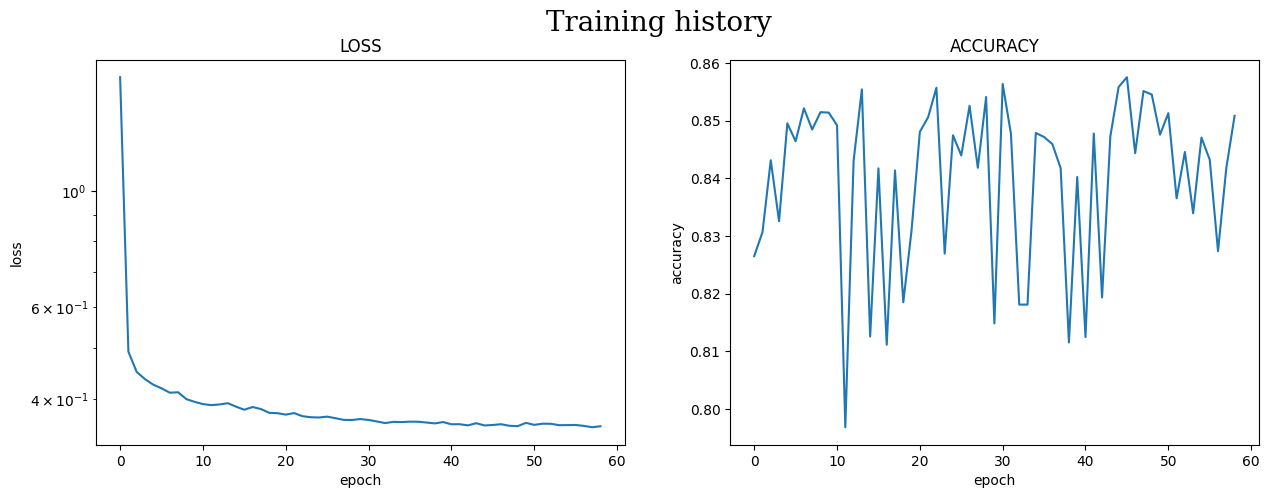

In [38]:
loss = history.history['loss']
val_accuracy = history.history['val_accuracy']

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot(loss, label='loss')
ax[1].plot(val_accuracy, label='val_accuracy')
ax[0].set(yscale='log', xlabel='epoch', ylabel='loss', title='LOSS')
ax[1].set(xlabel='epoch', ylabel='accuracy', title='ACCURACY')
plt.suptitle('Training history', fontsize=20, fontname='serif') 
plt.show()

In [39]:
loss = model.evaluate(test_data, test_target, verbose=0)
print('Loss, Accuracy =', *loss)

Loss, Accuracy = 0.34773609042167664 0.850806474685669


## Predict the data
Run the prediction of the model on the full (signal plus background) dataset of your
choice

In [40]:
all_data = shuffle(pd.concat([bgd_uncut.iloc[0:sig_uncut.shape[0]], sig_uncut], axis=0))
all_data_predict = np.array(all_data[input_variables])
all_data_true = np.array(all_data['isSignal'])
prediction = model.predict(all_data_predict)
prediction_bi = (prediction > 0.5).astype(int)

3126/3126 [==============================] - 8s 3ms/step


In [41]:
## counting the percentage of correct predictions ##
no_correct_bgd, no_correct_sig = 0, 0
for i in range(len(prediction_bi)):
    if prediction_bi[i] == all_data_true[i]:
        if all_data_true[i] == 0:
            no_correct_bgd += 1
        else:
            no_correct_sig += 1

### Finding the number of correctly predicted for bgd and sig

In [42]:
values01, counts01 = np.unique(all_data_true, return_counts=True)
print('correct bgd:',100*no_correct_bgd/counts01[0], '%')
print('correct sig',100*no_correct_sig/counts01[1], '%')
print('correct all:',100*(no_correct_bgd+no_correct_sig)/len(all_data_true), '%')

correct bgd: 88.08709735468778 %
correct sig 82.25861276068223 %
correct all: 85.172855057685 %


From the plot below you can see that a significant percentage of the bacground events are being predicted as signal events.

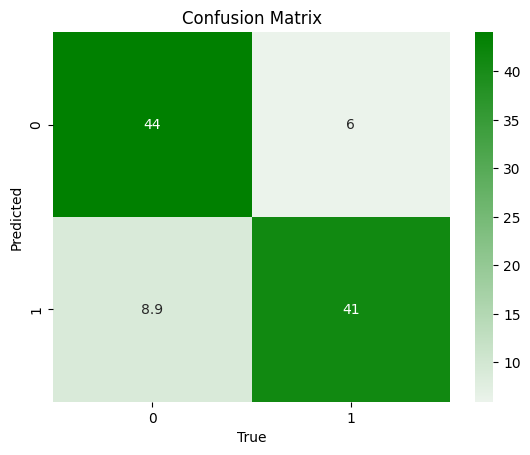

In [43]:
confusion_matrix = 100* metrics.confusion_matrix(all_data_true, prediction_bi)/len(all_data_true)
heatmap(confusion_matrix, labels=['True', 'Predicted'], title='Confusion matrix \npercentage occurances')

Here you can see that the background evnts that are incorrectly predicted as signal events are in the region where the signal is. However some of the true signal events have been predicted as background. The fitting may need more parameters to be able to properly predict the signal. The background therefore appeard to have a peak where the signal should be.

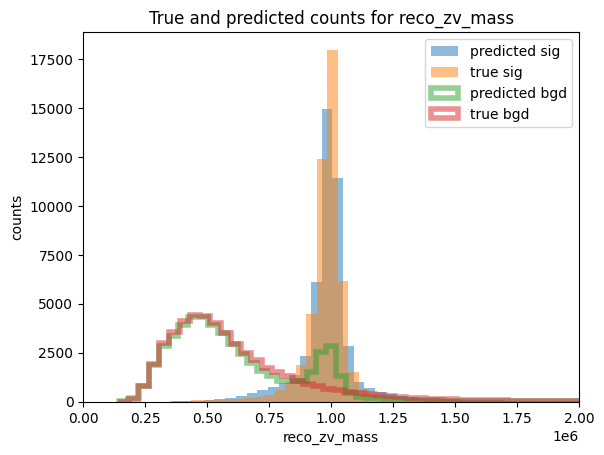

In [44]:
all_data['prediction'] = prediction_bi
plt.title('True and predicted counts for reco_zv_mass')
plt.xlabel('reco_zv_mass')
plt.ylabel('counts')
plt.hist(all_data[all_data['prediction'] == 1]['reco_zv_mass'], label='predicted sig', alpha=0.5, bins=100)
plt.hist(all_data[all_data['isSignal'] == 1]['reco_zv_mass'], label='true sig', alpha=0.5, bins=100)
plt.hist(all_data[all_data['prediction']==0]['reco_zv_mass'], label='predicted bgd', alpha=0.5, bins=100, histtype='step', lw=4)
plt.hist(all_data[all_data['isSignal']==0]['reco_zv_mass'], label='true bgd', alpha=0.5, bins=100, histtype='step', lw=4)
plt.xlim(0, 2e6)
plt.legend()
plt.show()

In [45]:
small_range_reco_zv_mass = all_data[(all_data['reco_zv_mass'] > low) & (all_data['reco_zv_mass'] < high)]
bgd_true_fit = small_range_reco_zv_mass[small_range_reco_zv_mass['isSignal'] == 0]
bgd_pred_fit = small_range_reco_zv_mass[small_range_reco_zv_mass['prediction'] == 0]
sig_true_fit = small_range_reco_zv_mass[small_range_reco_zv_mass['isSignal'] == 1]
sig_pred_fit = small_range_reco_zv_mass[small_range_reco_zv_mass['prediction'] == 1]

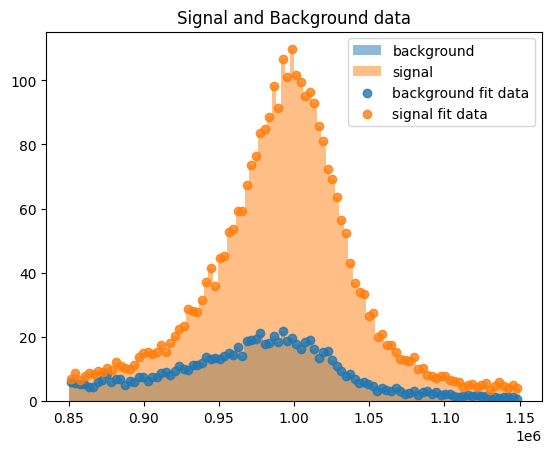

fraction of signal events: 39.841297693790345 %


In [46]:
plot_reco_zv_mass_hist(bgd_pred_fit, sig_pred_fit)
plt.show()

To prevent the background from being miss corrected  i will perfom traning with the loosely cut data. There will be less data to train on but hopefully the background will be more accuratly predicted.

I found that if i use the more harsh cut the background would be more likely to be predicted as the signal in the signal area.

In [47]:
train_data, test_data, train_target, test_target = get_train_test_split(bgd_loose_cut, sig_loose_cut, sig_loose_cut.shape[0])
callbacks_ = [EarlyStopping (verbose=True, patience=10, monitor='accuracy', mode='max'),
                ModelCheckpoint ('model.h5', monitor='accuracy', verbose=0, save_best_only=True, mode='max')]

model = my_model(train_data.shape[1], n_nodes, depth)
history = model.fit(train_data, train_target, epochs=N_epochs, batch_size=batchSize, 
                       validation_data=(test_data, test_target), verbose=0, callbacks=callbacks_)


Number of variables used:  8
Shapes of test train data:
 (69652, 8) (29852, 8) (69652, 1) (29852, 1)


c:\Users\hanna\Documents\University\Year 4\DAML\env\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 60: early stopping


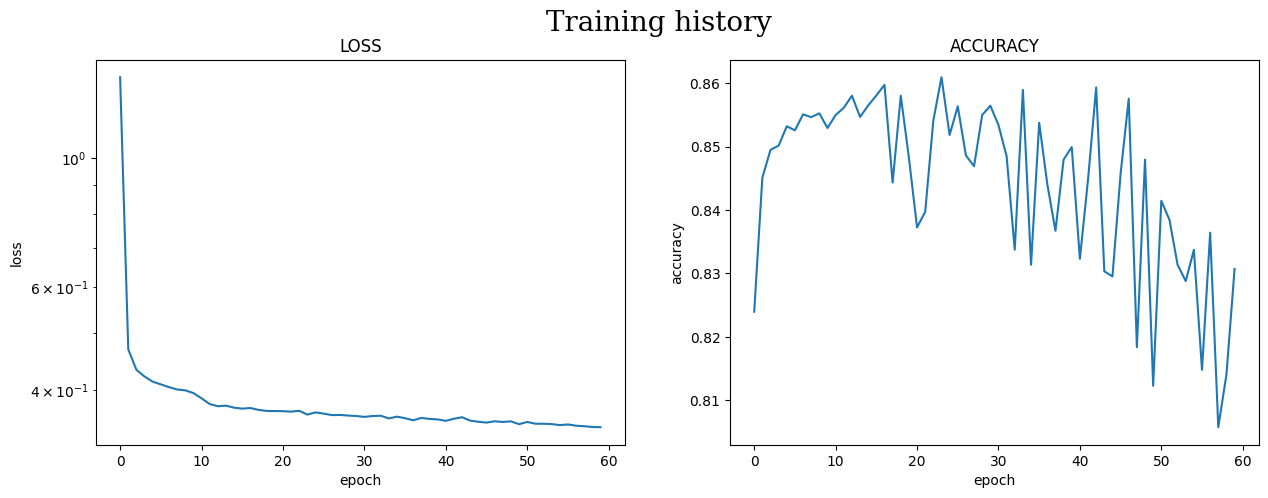

Loss, Accuracy = 0.3813893795013428 0.8306981325149536


In [48]:
loss = history.history['loss']
val_accuracy = history.history['val_accuracy']

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot(loss, label='loss')
ax[1].plot(val_accuracy, label='val_accuracy')
ax[0].set(yscale='log', xlabel='epoch', ylabel='loss', title='LOSS')
ax[1].set(xlabel='epoch', ylabel='accuracy', title='ACCURACY')
plt.suptitle('Training history', fontsize=20, fontname='serif') 
plt.show()

loss = model.evaluate(test_data, test_target, verbose=0)
print('Loss, Accuracy =', *loss)

#### Using the full dataset

In [49]:
all_data = shuffle(pd.concat([bgd_uncut, sig_uncut], axis=0)) # predicting with the full dataset as told to
all_data_predict = np.array(all_data[input_variables])
print('size of data: ',all_data.shape[0])
all_data_true = np.array(all_data['isSignal'])
prediction = model.predict(all_data_predict, batch_size=500)
prediction_bi = (prediction > 0.5).astype(int)
all_data['prediction'] = prediction_bi

## counting the percentage of correct predictions ##
no_correct_bgd, no_correct_sig = 0, 0
for i in range(len(prediction_bi)):
    if prediction_bi[i] == all_data_true[i]:
        if all_data_true[i] == 0:
            no_correct_bgd += 1
        else:
            no_correct_sig += 1

size of data:  6876972
13754/13754 [==============================] - 43s 3ms/step


correct bgd: 92.26731843563144 %
correct sig 73.49089236798433 %
correct all: 92.13076627329586 %


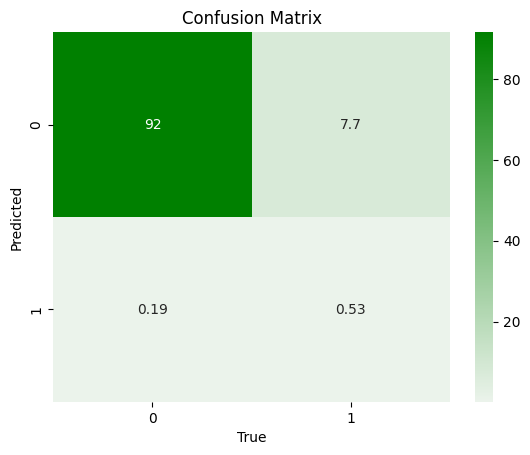

In [50]:
## printing the correctly predicted events ##
values01, counts01 = np.unique(all_data_true, return_counts=True)
print('correct bgd:',100*no_correct_bgd/counts01[0], '%')
print('correct sig',100*no_correct_sig/counts01[1], '%')
print('correct all:',100*(no_correct_bgd+no_correct_sig)/len(all_data_true), '%')

## plotting the matrix as a percentage of the totla number of points ##
confusion_matrix = 100*metrics.confusion_matrix(all_data_true, prediction_bi)/len(all_data_true)
heatmap(confusion_matrix, labels=['True', 'Predicted'], title='Confusion matrix \npercentage occurances')
plt.show()

In [51]:
## chnagin the rages to plot the predictions ##
small_range_reco_zv_mass = all_data[(all_data['reco_zv_mass'] > 0.5e6) & (all_data['reco_zv_mass'] < 2e6)]
bgd_true_fit = small_range_reco_zv_mass[small_range_reco_zv_mass['isSignal'] == 0]
bgd_pred_fit = small_range_reco_zv_mass[small_range_reco_zv_mass['prediction'] == 0]
sig_true_fit = small_range_reco_zv_mass[small_range_reco_zv_mass['isSignal'] == 1]
sig_pred_fit = small_range_reco_zv_mass[small_range_reco_zv_mass['prediction'] == 1]

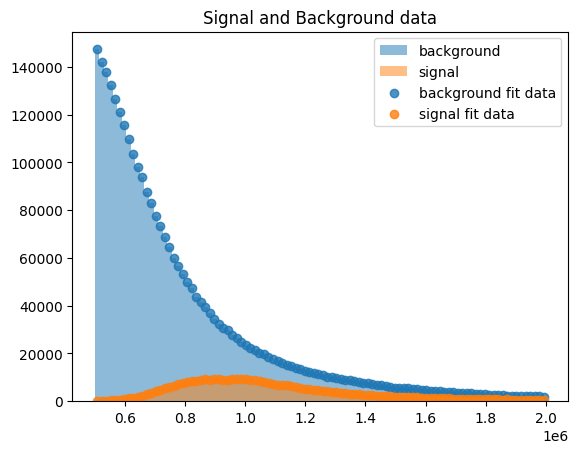

fraction of signal events: 5.71374347935511 %


In [52]:
bgdx, bgdy, bgd_sumweight_sq, bgd_sumweight, sigx, sigy, sig_sumweight_sq, sig_sumweight = plot_reco_zv_mass_hist(bgd_pred_fit, sig_pred_fit)
plt.show()

### Fitting seperatly then together

In [53]:
def gaussian( x, mean, sigma1, sigma2, a, b):
    g1 = a * np.exp( - 0.5 * ( (x-mean)/sigma1 )**2)
    g2 = b * np.exp( - 0.5 * ( (x-mean)/sigma2 )**2)
    return g1 + g2
# def lorentzian( x, mean, gamma, a):
#     return a / (1 + ((x-mean)/gamma)**2)
def line( x, intercept, slope ):
    return intercept + slope * x


## to fit signal alone ##
def chi2_sig_gauss( mean, sigma1, sigma2, a, b): # signal present 
    n_pred = gaussian( sigx, mean, sigma1, sigma2, a, b )
    # n_pred[n_pred<=0] = 1e-5  # to prevent dividing by 0
    return np.sum((sig_sumweight - n_pred)**2 / sig_sumweight_sq)


def chi2_bgd_lorentz( mean, gamma, a): # signal present 
    n_pred = lorentzian( bgdx, mean, gamma, a)
    return np.sum((bgd_sumweight - n_pred)**2 / bgd_sumweight_sq)
# ## to fit background alone ##
# def chi2_bgd( intercept, slope ): # signal present 
#     n_pred = line( bgdx, intercept, slope )
#     return np.sum((bgd_sumweight - n_pred)**2 / bgd_sumweight_sq)

In [54]:
bgd_lorentz_startvals = {'mean':0, 'gamma':1, 'a':100}
m_bgd = Minuit(chi2_bgd_lorentz, **bgd_lorentz_startvals)
m_bgd.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 6397                       │              Nfcn = 292              │
│ EDM = 7.91e-07 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ mean  │  523.2e3  │   0.6e3   │            │            │         │         │       │
│ 1 │ gamma │ 211.51e3  │  0.27e3   │            │            │         │         │       │
│ 2 │ a     │ 135.61e3  │  0.26e3   │            │            │         │         │       │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───────┬────────────────────────────┐
│       │     mean    gamma        a │
├───────┼────────────────────────────┤
│  mean │ 3.27e+05  -0.05e6  -0.11e6 │
│ gamma │  -0.05e6 7.15e+04  -0.02e6 │
│     a │  -0.11e6  -0.02e6 6.94e+04 │
└───────┴────────────────────────────┘

In [55]:
sig_startvals_gauss = {'mean':0.8e6, 'sigma1':0.5e6, 'sigma2':0.5e6, 'a':1, 'b':1}
m_sig = Minuit(chi2_sig_gauss, **sig_startvals_gauss)
m_sig.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 2.099e+04                  │              Nfcn = 314              │
│ EDM = 1.31e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │     Covariance FORCED pos. def.      │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ mean   │ 1.0362e6  │ 0.0009e6  │            │            │         │         │       │
│ 1 │ sigma1 │ -219.9e3  │   3.0e3   │            │            │         │         │       │
│ 2 │ sigma2 │ -219.9e3  │   3.0e3   │            │            │         │         │       │
│ 3 │ a      │  4.45e3   │  0.31e3   │            │            │         │         │       │
│ 4 │ b      │  4.48e3   │  0.31e3   │            │            │         │         │       │
└───┴────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────────┬──────────────────────────────────────────────┐
│        │     mean   sigma1   sigma2        a        b │
├────────┼──────────────────────────────────────────────┤
│   mean │  7.5e+05   -0.4e6   -0.4e6  -0.01e6  -0.01e6 │
│ sigma1 │   -0.4e6 9.25e+06     -8e6  -0.01e6   0.02e6 │
│ sigma2 │   -0.4e6     -8e6 9.15e+06   0.02e6  -0.01e6 │
│      a │  -0.01e6  -0.01e6   0.02e6 9.61e+04   -0.1e6 │
│      b │  -0.01e6   0.02e6  -0.01e6   -0.1e6 9.61e+04 │
└────────┴──────────────────────────────────────────────┘

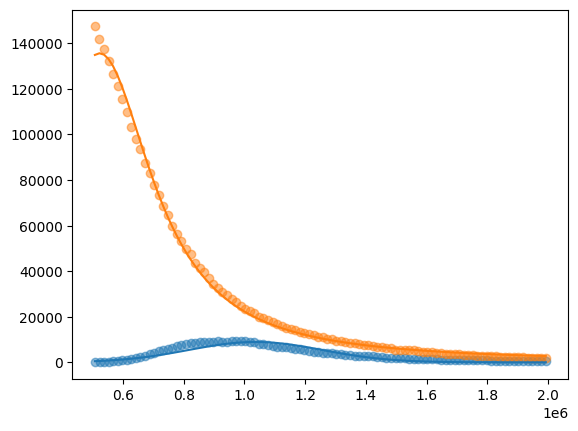

In [56]:
plt.plot(sigx, gaussian(sigx, *m_sig.values), label='signal fit')
plt.plot(bgdx, lorentzian(bgdx, *m_bgd.values), label='background fit')
plt.scatter(sigx, sigy, label='signal data', alpha=0.5)
plt.scatter(bgdx, bgdy, label='background data', alpha=0.5)
plt.show()

### Fitting the combined signal and background for H1

In [57]:
## for fitting the combined signal and background ##
def bgd_sig(x, mean, gamma, a, c):
    return lorentzian( x, mean, gamma, a ) + c * gaussian(sigx, *m_sig.values)


def chi2_combined(mean, gamma, a, c):
    n_pred = bgd_sig(bgdx, mean, gamma, a, c)
    y = bgd_sumweight + sig_sumweight
    y_sum_sq = bgd_sumweight_sq + sig_sumweight_sq
    return np.sum((y-n_pred)**2 / y_sum_sq)

In [58]:
combined_startvals = {'mean':m_bgd.values[0], 'gamma':m_bgd.values[1], 'a':m_bgd.values[2], 'c':1}
m_comb = Minuit(chi2_combined, **combined_startvals)
m_comb.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 3517                       │              Nfcn = 100              │
│ EDM = 1.7e-05 (Goal: 0.0002)     │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ mean  │  516.2e3  │   0.7e3   │            │            │         │         │       │
│ 1 │ gamma │  220.9e3  │   0.4e3   │            │            │         │         │       │
│ 2 │ a     │ 136.48e3  │  0.28e3   │            │            │         │         │       │
│ 3 │ c     │   0.947   │   0.009   │            │            │         │         │       │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───────┬─────────────────────────────────────────┐
│       │      mean     gamma         a         c │
├───────┼─────────────────────────────────────────┤
│  mean │  4.35e+05   -0.09e6   -0.14e6 587.57e-3 │
│ gamma │   -0.09e6  1.82e+05   -0.02e6  -2.60692 │
│     a │   -0.14e6   -0.02e6  8.03e+04 107.93e-3 │
│     c │ 587.57e-3  -2.60692 107.93e-3  7.77e-05 │
└───────┴─────────────────────────────────────────┘

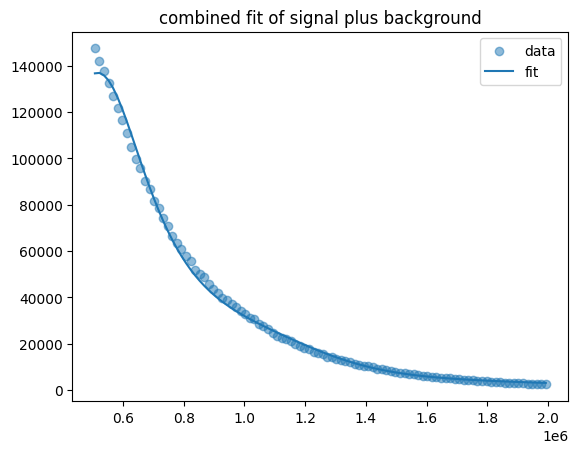

In [59]:
plt.scatter(bgdx, sigy+bgdy, alpha=0.5, label='data')
plt.plot(bgdx, bgd_sig(bgdx, *m_comb.values), label='fit')
plt.title('combined fit of signal plus background')
plt.legend()
plt.show()

### Fitting just Background for H0

In [60]:
def chi2_just_bgd_lorentz( mean, gamma, a): # signal present 
    n_pred = lorentzian( bgdx, mean, gamma, a)
    return np.sum((bgd_sumweight+sig_sumweight - n_pred)**2 / (bgd_sumweight_sq+sig_sumweight_sq))

In [61]:
just_bgd_startvals = {'mean':m_bgd.values[0], 'gamma':m_bgd.values[1], 'a':m_bgd.values[2]}
m_just_bgd = Minuit(chi2_just_bgd_lorentz, **just_bgd_startvals)
m_just_bgd.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 1.494e+04                  │              Nfcn = 76               │
│ EDM = 5.14e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ mean  │  517.1e3  │   0.7e3   │            │            │         │         │       │
│ 1 │ gamma │ 251.27e3  │  0.31e3   │            │            │         │         │       │
│ 2 │ a     │ 133.32e3  │  0.27e3   │            │            │         │         │       │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───────┬────────────────────────────┐
│       │     mean    gamma        a │
├───────┼────────────────────────────┤
│  mean │  4.7e+05  -0.05e6  -0.14e6 │
│ gamma │  -0.05e6 9.68e+04  -0.03e6 │
│     a │  -0.14e6  -0.03e6 7.31e+04 │
└───────┴────────────────────────────┘

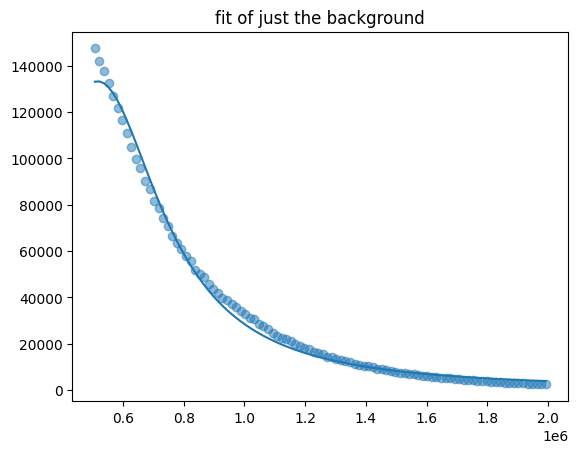

In [62]:
plt.scatter(bgdx, bgdy+sigy, label='data', alpha=0.5)
plt.plot(bgdx, lorentzian(bgdx, *m_just_bgd.values), label='fit')
plt.title('fit of just the background')
plt.show()

The p-value below is so low it is approximated as being zero due to zero point floating errors.
I would consider the ML part as doing worse due to the confusion with the signal and background characterisation being wrong in the signal region.
This causes the shapes of the background to be wrong in the signal region, and therefore messes with the fit. It also affects the shape of the signal to be much sider than is it supposed to be.

In [63]:
chi2_H0 = m_just_bgd.fval
chi2_H1 = m_comb.fval
# calculate relevent values
chi2_diff = chi2_H0 - chi2_H1
p_value = 1-chi2.cdf(chi2_diff, 1)
std = erfinv(1 - p_value) * np.sqrt(2)
print('Chi^2 H_0=', round(chi2_H0, 3), '\nChi^2 H_1=', round(chi2_H1, 3))
print('Chi^2 diff:', round(chi2_diff, 3))
print('\np-value:', p_value, '\nstd:', round(std, 1))

Chi^2 H_0= 14942.846 
Chi^2 H_1= 3516.995
Chi^2 diff: 11425.85

p-value: 0.0 
std: inf


The result is worse than the previous section

# 6 Impact of training sample on classifier

In [64]:
## make 50-50 split bgd and sig ##
input_cols = ['lep1_pt', 'lep2_pt', 'fatjet_pt', 'fatjet_eta', 'fatjet_D2', 'Zll_mass', 'Zll_pt', 'MET', 'reco_zv_mass'] 
print(target_variable)

def get_train_test_split(bgd_data, sig_data, counts):
    split_data = pd.concat([shuffle(bgd_data, random_state=42).iloc[0:counts], sig_data], axis=0, ignore_index=True)
    split_data = shuffle(split_data, random_state=42)
    input_data = split_data[input_cols] # restrict to input variables
    target = split_data[target_variable] # restrict to IsSignal
    print('Number of variables used: ', len(input_cols))

    train_data, test_data, train_target, test_target = model_selection.train_test_split(input_data, target, 
                                                                                        test_size=0.3, 
                                                                                        random_state=42)
    print('Shapes of test train data:\n',
        train_data.shape, test_data.shape, train_target.shape, test_target.shape)

    return train_data, test_data, train_target, test_target

['isSignal']


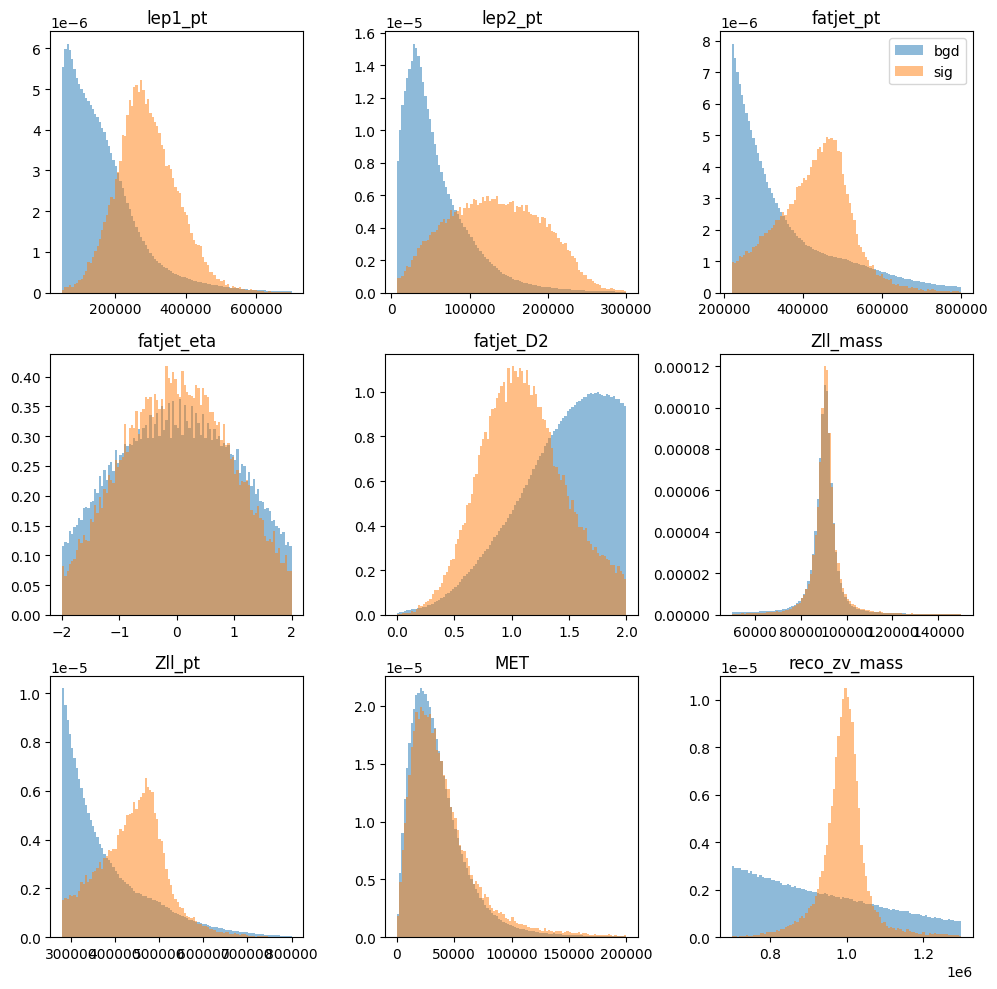

(370593, 24) (38890, 24)
38890 370593


In [65]:
cut_dict = {'lep1_pt': (0.05e6, 0.7e6), 'lep2_pt':(0, .3e6), 'fatjet_pt':(0.22e6, .8e6), 'fatjet_eta':(-2, 2), 
            'fatjet_D2':(0, 2), 'Zll_mass':(0.05e6, 0.15e6), 'Zll_pt':(0.28e6, 0.8e6), 'MET':(0, 0.2e6), 
            'reco_zv_mass': (0.7e6, 1.3e6)}
bgd_data, sig_data, sig_count, bgd_count = perform_cuts(cut_dict, cut_reco=True)
print(sig_count, bgd_count)

In [66]:
## make 50-50 split bgd and sig ##
def get_train_test_split(bgd_data, sig_data, counts):
    split_data = pd.concat([shuffle(bgd_data, random_state=42).iloc[0:counts], sig_data], axis=0, ignore_index=True)
    split_data = shuffle(split_data, random_state=42)
    input_data = split_data[input_cols] # restrict to input variables
    target = split_data[target_variable] # restrict to IsSignal
    print('Number of variables used: ', len(input_variables))

    train_data, test_data, train_target, test_target = model_selection.train_test_split(input_data, target, 
                                                                                        test_size=0.3, 
                                                                                        random_state=42)
    print('Shapes of test train data:\n',
        train_data.shape, test_data.shape, train_target.shape, test_target.shape)

    return train_data, test_data, train_target, test_target

In [67]:
def new_model(num_inputs, num_nodes, extra_depth, metric='accuracy'):
    ## create model ##
    model = Sequential()
    model.add(Dense(num_nodes, input_dim=num_inputs, kernel_initializer='normal', activation='relu'))
    model.add(Dropout(0.2))

    ## adding the layers ##
    for i in range(extra_depth):
        model.add(Dense(num_nodes, kernel_initializer='normal', activation='relu'))
        if i%3 == 0:
            model.add(Dropout(0.1))
    
    model.add(Dense(num_outputs, activation='sigmoid'))
    ## Compile model ##
    model.compile(optimizer='Adam', loss='binary_crossentropy', metrics=[metric])
    return model

In [68]:
train_data, test_data, train_target, test_target = get_train_test_split(bgd_data, sig_data, sig_count)
print(len(input_cols), train_data.shape[1])
second_model = new_model(len(input_cols), n_nodes, depth)
history = second_model.fit(train_data, train_target, epochs=N_epochs, batch_size=batchSize, 
                       validation_data=(test_data, test_target), verbose=1, callbacks=callbacks_)

Number of variables used:  8
Shapes of test train data:
 (54446, 9) (23334, 9) (54446, 1) (23334, 1)
9 9
Epoch 1/100
109/109 [==============================] - 4s 10ms/step - loss: 2.6895 - accuracy: 0.5171 - val_loss: 0.6859 - val_accuracy: 0.5540
Epoch 2/100
109/109 [==============================] - 1s 7ms/step - loss: 0.7126 - accuracy: 0.5399 - val_loss: 0.6819 - val_accuracy: 0.5847
Epoch 3/100
109/109 [==============================] - 1s 6ms/step - loss: 0.6892 - accuracy: 0.5617 - val_loss: 0.6689 - val_accuracy: 0.6335
Epoch 4/100
109/109 [==============================] - 1s 6ms/step - loss: 0.6807 - accuracy: 0.5795 - val_loss: 0.6552 - val_accuracy: 0.6380
Epoch 5/100
109/109 [==============================] - 1s 6ms/step - loss: 0.6711 - accuracy: 0.6013 - val_loss: 0.6481 - val_accuracy: 0.6298
Epoch 6/100
109/109 [==============================] - 1s 6ms/step - loss: 0.6643 - accuracy: 0.6079 - val_loss: 0.6394 - val_accuracy: 0.6350
Epoch 7/100
109/109 [===============

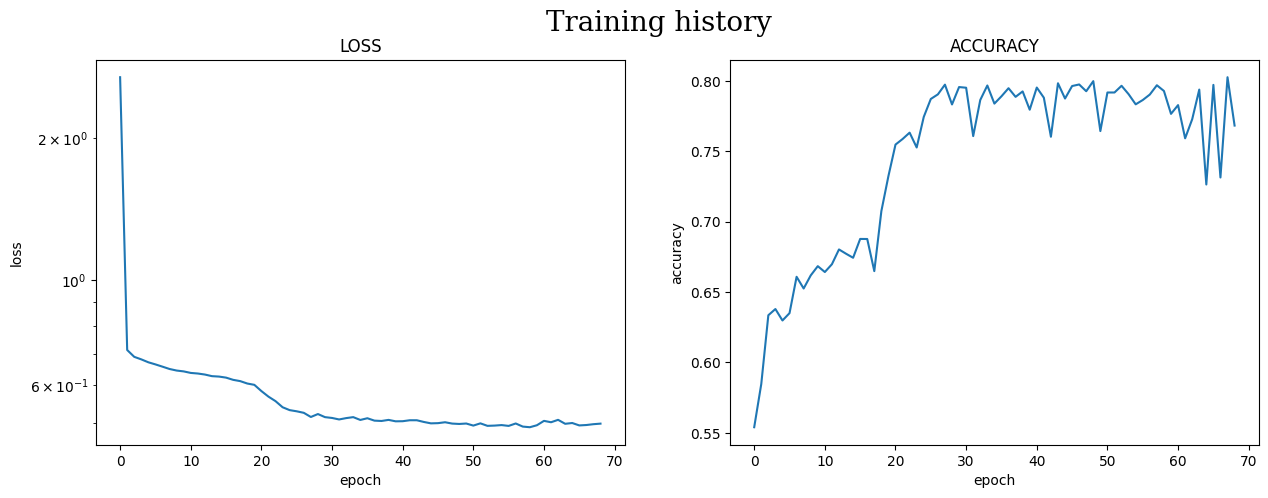

Loss, Accuracy = 0.5135184526443481 0.7681923508644104


In [69]:
loss = history.history['loss']
val_accuracy = history.history['val_accuracy']

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot(loss, label='loss')
ax[1].plot(val_accuracy, label='val_accuracy')
ax[0].set(yscale='log', xlabel='epoch', ylabel='loss', title='LOSS')
ax[1].set(xlabel='epoch', ylabel='accuracy', title='ACCURACY')
plt.suptitle('Training history', fontsize=20, fontname='serif') 
plt.show()

loss = second_model.evaluate(test_data, test_target, verbose=0)
print('Loss, Accuracy =', *loss)

In [70]:
all_data = shuffle(pd.concat([bgd_uncut, sig_uncut], axis=0))
all_data_predict = np.array(all_data[input_cols])
all_data_true = np.array(all_data['isSignal'])
prediction = second_model.predict(all_data_predict, batch_size=500)
prediction_bi = (prediction > 0.5).astype(int)
all_data['prediction'] = prediction_bi

## counting the percentage of correct predictions ##
no_correct_bgd, no_correct_sig = 0, 0
for i in range(len(prediction_bi)):
    if prediction_bi[i] == all_data_true[i]:
        if all_data_true[i] == 0:
            no_correct_bgd += 1
        else:
            no_correct_sig += 1

13754/13754 [==============================] - 37s 3ms/step


it is correctly predicting with higher percentages than previously

correct bgd: 96.28528602559354 %
correct sig 64.72517145542159 %
correct all: 96.05576407756205 %


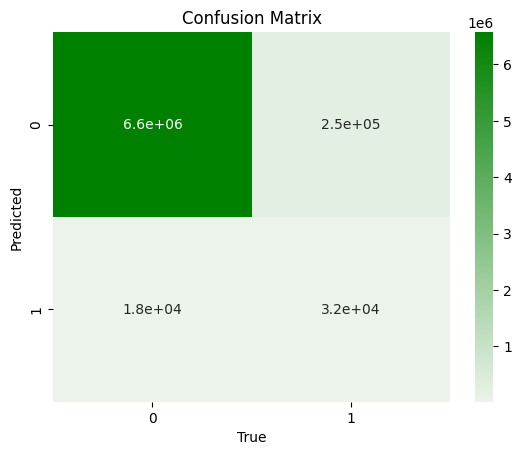

In [71]:
values01, counts01 = np.unique(all_data_true, return_counts=True)
print('correct bgd:',100*no_correct_bgd/counts01[0], '%')
print('correct sig',100*no_correct_sig/counts01[1], '%')
print('correct all:',100*(no_correct_bgd+no_correct_sig)/len(all_data_true), '%')

confusion_matrix = metrics.confusion_matrix(all_data_true, prediction_bi)
heatmap(confusion_matrix, labels=['True', 'Predicted'], title='Confusion matrix \npercentage occurances')

percentage of signal found in prediction: 484 %
signal percentage of total: 19 %


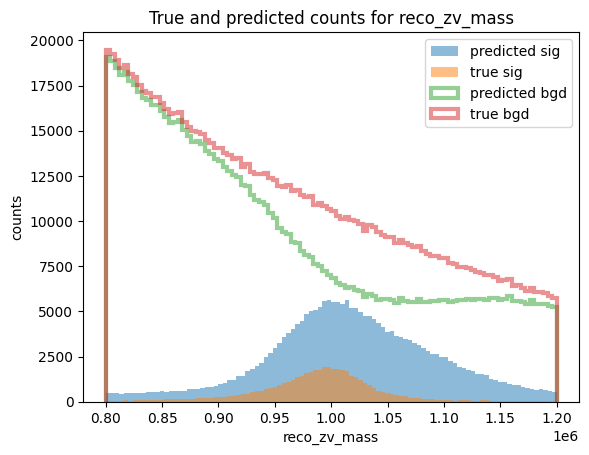

In [72]:
low, high = 0.8e6, 1.2e6
sig_prediction = all_data[(all_data['prediction'] == 1) & (all_data['reco_zv_mass'] < high) & (all_data['reco_zv_mass'] > low)]
sig_true = all_data[(all_data['isSignal'] == 1) & (all_data['reco_zv_mass'] < high) & (all_data['reco_zv_mass'] > low)]
bgd_prediction = all_data[(all_data['prediction']==0) & (all_data['reco_zv_mass'] < high) & (all_data['reco_zv_mass'] > low)]
bgd_true = all_data[(all_data['isSignal']==0) & (all_data['reco_zv_mass'] < high) & (all_data['reco_zv_mass'] > low)]

plt.title('True and predicted counts for reco_zv_mass')
plt.xlabel('reco_zv_mass')
plt.ylabel('counts')
plt.hist(sig_prediction['reco_zv_mass'], label='predicted sig', alpha=0.5, bins=100)
plt.hist(sig_true['reco_zv_mass'], label='true sig', alpha=0.5, bins=100)
plt.hist(bgd_prediction['reco_zv_mass'], label='predicted bgd', alpha=0.5, bins=100, histtype='step', lw=3)
plt.hist(bgd_true['reco_zv_mass'], label='true bgd', alpha=0.5, bins=100, histtype='step', lw=3)
plt.legend()
print('percentage of signal found in prediction:', round(100*sig_prediction.shape[0]/sig_true.shape[0]), '%')
print('signal percentage of total:', round(100*sig_prediction.shape[0]/(sig_prediction.shape[0] + bgd_prediction.shape[0])), '%')
plt.show()

## Discuss the reasons for the behaviour of the ML classifier after incorporating variable reco_zv_mass in the NN training, and its impact on the search sensitivity

Before without incorperatng reco_zv_mass the signal was predicted correcly with some of the background being predicted incorrectly, however when it is encorperated the prediction is overestimated with the background being underestimated.

However incorperating reco_zv_mass if done with more care can increase the sensitivity of the search as the percentage of the signal has gonw up considerably. The signal shape is the same with an observable approximate mean, but with a strong er signal. This could be used to strengthen it if done properly. The background has also retained a similar shape but with a dip due to the over estimation of the signal - if but the signal is fitted in isolate without the background being incorperated it enhaces the signal strength.

In future I would remove a couple of the variables where the background and signal completely overlap as being the same for example the Zll_mass and MET - to see if ti would have an effect. They still may improve the fitting but this is hard to say unless tested.

Given more computing power or time it would be interesting to do a MC simulation of predicting the signal and background as what I haev done int he last section over and over again.